In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import sparse

# Load Data 

In [30]:
class Imgvox():
    PATH_TO_CHUNKS = Path(r"../dataset/data/")

    def __init__(self, path_to_data = None):
        if path_to_data:
            self.PATH_TO_CHUNKS = Path(path_to_data)
        self.img_files = sorted(list(self.PATH_TO_CHUNKS.glob("chunk_*/images/*.npz")))
        self.vox_files = sorted(list(self.PATH_TO_CHUNKS.glob("chunk_*/voxels/*.npz")))

        self.im_ids = list(map(self.get_id, self.img_files))
        self.vox_ids = list(map(self.get_id, self.vox_files))

        self.cached_files = dict()

    def get_files_by_index(self, idx):
        return self.img_files[idx], self.vox_files[idx]
    
    def get_files_by_id(self, id):
        #TODO
        pass

    def get_item(self, idx):
        # This fuction can be used as the __getitem__ method of a torch Dataset - arrays then have to be converted to torch tensors
        if idx in self.cached_files:
            img, vox = self.cached_files[idx]
        else:
            img_file, vox_file = self.get_files_by_index(idx)
            # load sample
            img_sparse = sparse.load_npz(img_file)
            vox_sparse = sparse.load_npz(vox_file)

            # unfold to dense 
            img = img_sparse.todense()
            vox = vox_sparse.todense().astype(bool)

            #add sample to cache
            self.cached_files[idx] = (img, vox)

        return img, vox
    
    @staticmethod
    def get_id(filename):
        return filename.name.split("_")[1].split(".")[0]
    
    @staticmethod
    def plot_2d_views(imgs):
        size=imgs.shape[-1]
        views=imgs #the imgs are in the rights order (top, front, side) to be interpreted as views

        drawing=np.zeros((2*size,2*size))
        drawing[:size,:size]=views[0]
        drawing[size:2*size,:size]=views[1]
        drawing[:size,size:2*size]=views[2]

        plt.imshow(drawing, cmap='gray')

    @staticmethod
    def plot_3d_slices(sample3d, total_slices=32):

        #log 3D slices
        resolution=sample3d.shape[-1] #resolution
        total_per_row=total_slices

        height=resolution
        weight=total_per_row*resolution

        grid=np.zeros((1, height, weight))

        ground_truth = sample3d[::resolution//total_per_row]

        for col in range(total_per_row):
                grid[0][0:resolution, col*resolution:(col+1)*resolution]=ground_truth[col]

        fig = plt.figure(figsize=(42,8))

        plt.imshow(grid[0], cmap='gray')

    def __len__(self):
        return len(self.img_files)
    
    def check_data_integrity(self, reload_files = False):
        if reload_files:
            self.img_files = sorted(list(self.PATH_TO_CHUNKS.glob("chunk_*/images/*.npz")))
            self.vox_files = sorted(list(self.PATH_TO_CHUNKS.glob("chunk_*/voxels/*.npz")))

            self.im_ids = list(map(self.get_id, self.img_files))
            self.vox_ids = list(map(self.get_id, self.vox_files))

        all_ids = sorted(self.im_ids) # sorted(im_vox) contains the exact same ids  as sorted(vox_ids)
        check_total_files = len(self.img_files) == len(self.vox_files) == len(all_ids) 
        check_complete = True if len(self.img_files) == len(self.vox_files) == len(all_ids) == 812294 else False
        check_id_match = sorted(self.im_ids)== sorted(self.vox_ids)
        check_unique = len(set(self.im_ids))==len(self.img_files) and len(set(self.vox_ids))==len(self.vox_files)

        check_intergrity = check_total_files and check_id_match and check_unique

        print("Check: total files: {}".format("Ok" if check_total_files else "Fail"))
        print("Check: match pairs: {}".format("Ok" if check_id_match else "Fail"))
        print("Check: unique ids : {}".format("Ok" if check_unique else "Fail"))

        if check_complete:
            print(f"\ndataset valid: {check_intergrity}")
        else:
            print(f"\nINFO: You use a subset of the dataset. The dataset is not complete.")
            print(f"dataset valid: {check_intergrity}")

        


In [31]:
#init dataset
imgvox = Imgvox()

In [32]:
#check data integrity
imgvox.check_data_integrity(reload_files=False)

Check: total files: Ok
Check: match pairs: Ok
Check: unique ids : Ok

dataset valid: True


In [33]:
#load one sample

#select random sample
idx = np.random.randint(len(imgvox))

item2d, item3d = imgvox.get_item(idx)

In [34]:
#check shapes
item2d.shape, item3d.shape

((3, 224, 224), (128, 128, 128))

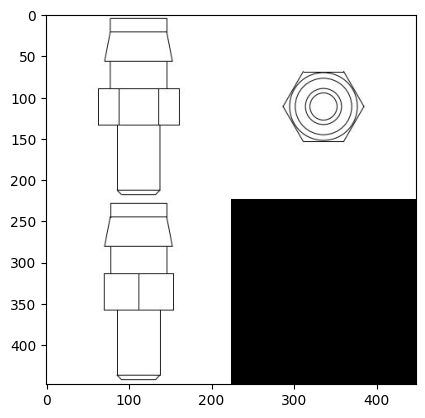

In [35]:
#plot 2d views
Imgvox.plot_2d_views(item2d)

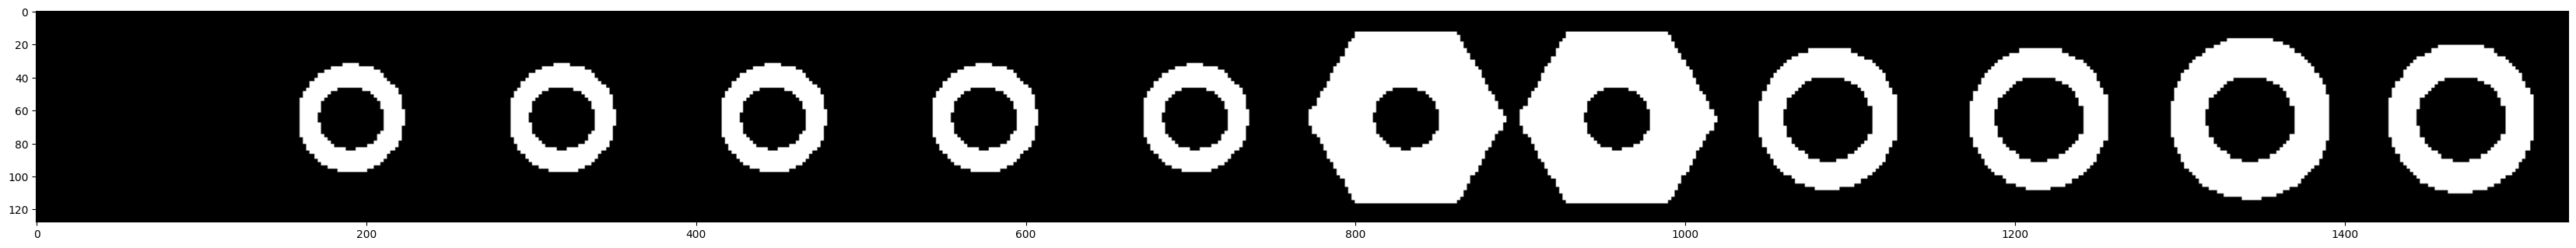

In [36]:
#plot 3d slices
Imgvox.plot_3d_slices(item3d, total_slices=12)